In [1]:
import fitsio
import numpy as np
import proplot as pplt
from esutil.stat import Binner

In [2]:
while True:
    try:
        d = fitsio.read("cte_data.fits")
    except Exception:
        continue
    else:
        break

print("# of unique tiles:", len(np.unique(d["tilename"])))
print("# of data points per bin:", d.shape[0]//32)

# of unique tiles: 8451
# of data points per bin: 1448878


In [3]:
import tqdm

rows = []
e1s = []
e2s = []
ns = []
e1s_err = []
e2s_err = []
for b in tqdm.trange(32, ncols=79):
    msk = (d["bin"] == b) & (d["n"] > 0)
    n = np.sum(d["n"][msk])
    ns.append(n)
    rows.append(np.sum(d["row"][msk])/n)
    e1s.append(np.sum(d["e1"][msk])/n)
    e1s_err.append(np.std(d["e1"][msk])/n * np.sqrt(np.sum(msk)))
    e2s.append(np.sum(d["e2"][msk])/n)
    e2s_err.append(np.std(d["e2"][msk])/n * np.sqrt(np.sum(msk)))
    
ns = np.array(ns)
rows = np.array(rows)
e1s = np.array(e1s)
e1s_err = np.array(e1s_err)
e2s = np.array(e2s)
e2s_err = np.array(e2s_err)

100%|██████████████████████████████████████████| 32/32 [00:46<00:00,  1.47s/it]


(-0.005, 0.005)

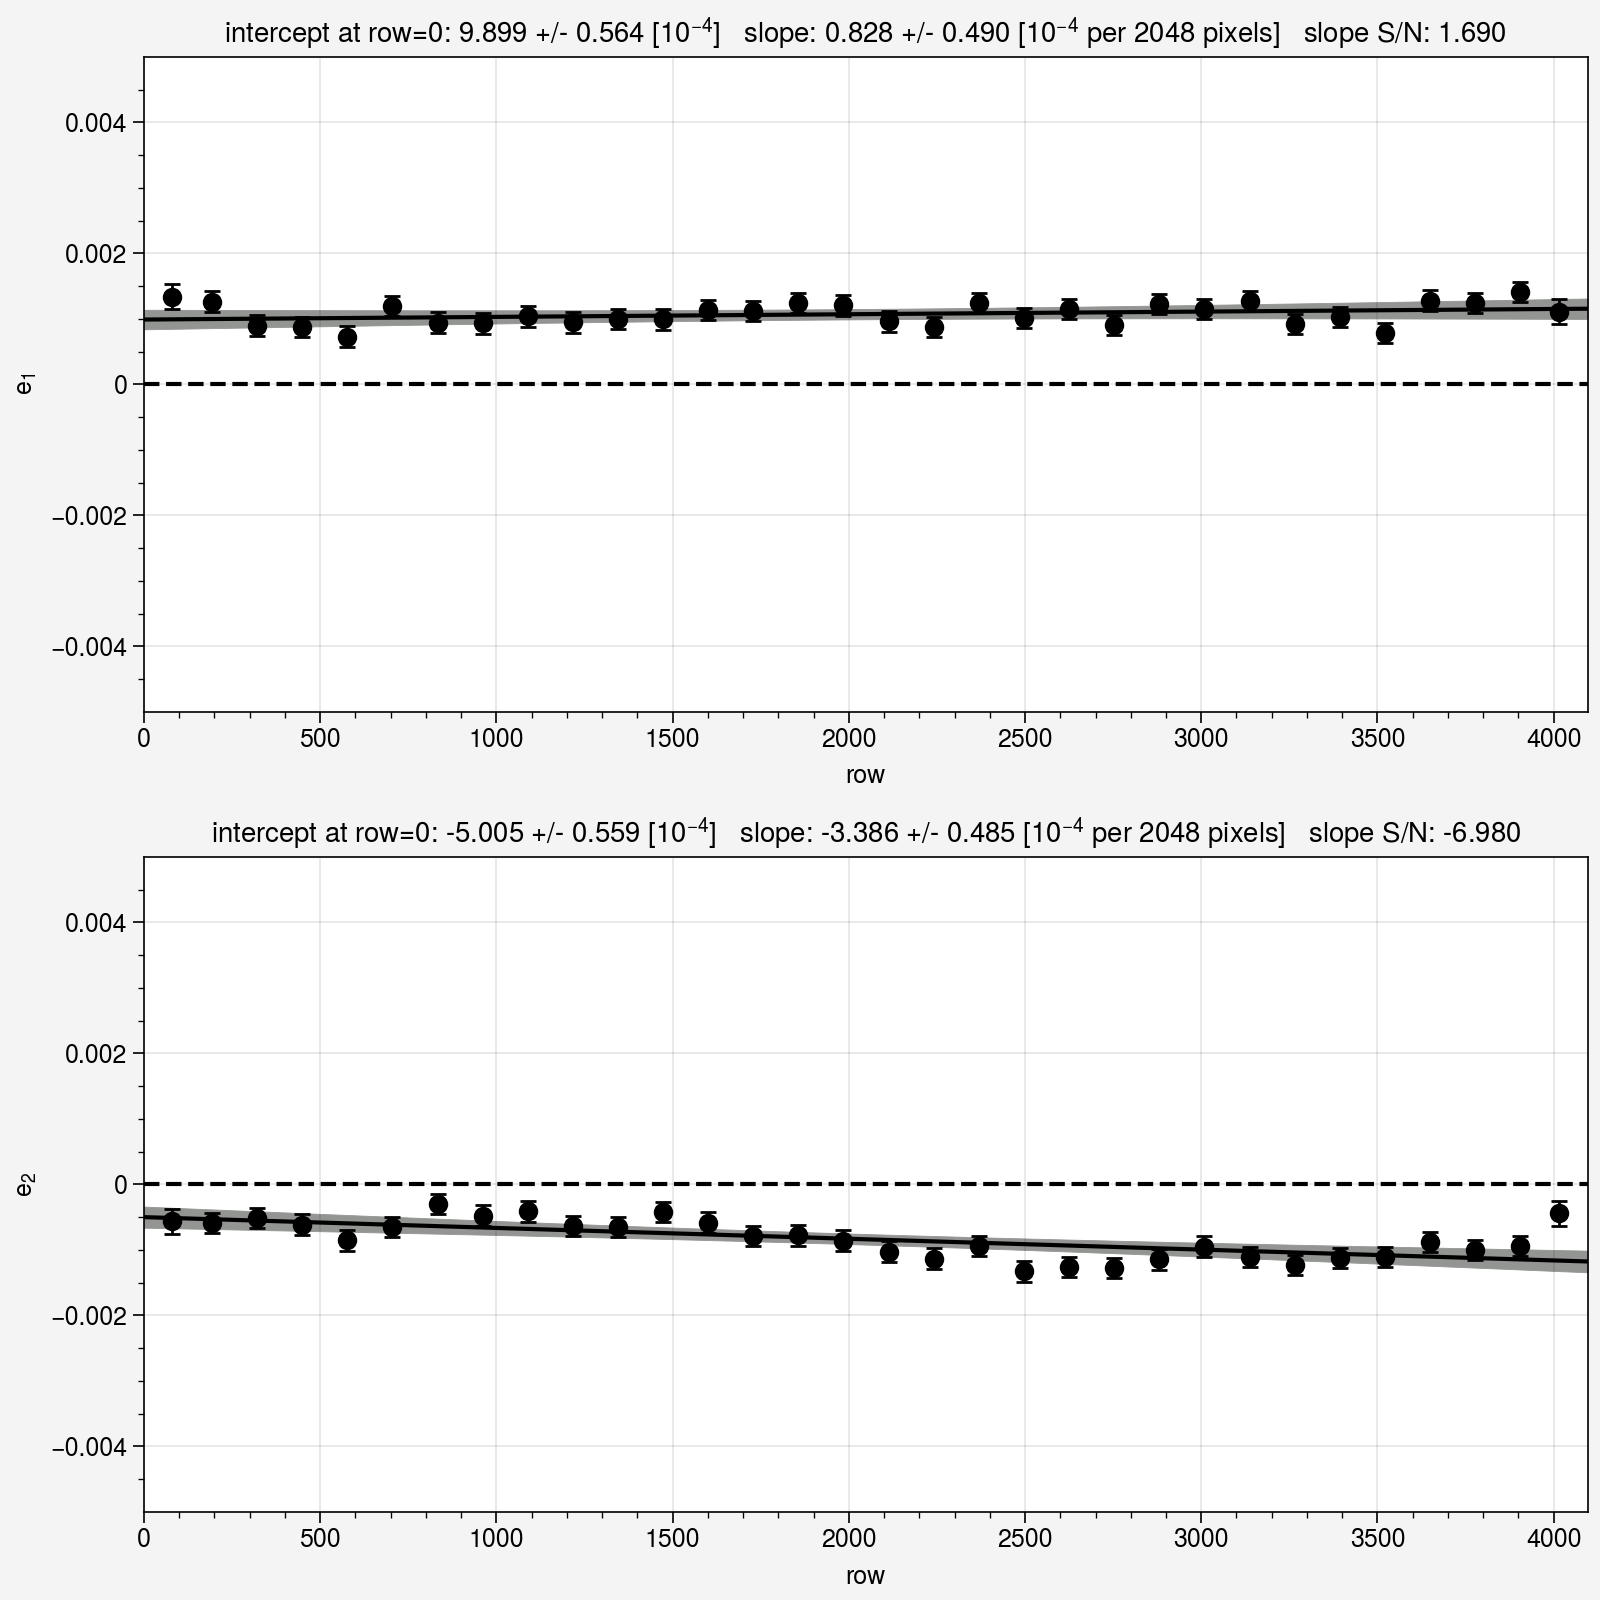

In [4]:
from scipy.optimize import curve_fit

def lin(x, m, c):
    return x/2048*m + c
    

def _fit_and_plot(rows, e, e_err, axs):
    r = curve_fit(lin, rows, e, sigma=e_err, absolute_sigma=True)
    xp = np.linspace(0, 4096, 100)
    yp = lin(xp, *r[0])

    vals = []
    for i in range(200):
        p = np.random.multivariate_normal(r[0], r[1])
        vals.append(lin(xp, *p))
    err = np.std(np.array(vals), axis=0)*3

    axs.plot(xp, yp, color='k')
    axs.fill_between(xp, yp-err, yp+err, color="gray")

    axs.plot(rows, e, "ko", bardata=e1s_err)

    axs.set_xlim(0, 4096)
    axs.axhline(0, color="k", linestyle="dashed")

    p = -4 # int(np.floor(np.log10(np.abs(r[0][0]))))

    axs.set_title(
        "intercept at row=0: %0.3f +/- %0.3f [$10^{-4}$]   "
        "slope: %0.3f +/- %0.3f [$10^{%s}$ per 2048 pixels]   "
        "slope S/N: %0.3f" % (
            r[0][1]/1e-4,
            np.sqrt(np.diagonal(r[1]))[1]/1e-4,
            r[0][0]/10**p,
            np.sqrt(np.diagonal(r[1]))[0]/10**p,
            str(p),
            r[0][0]/np.sqrt(r[1][0, 0])
        ),
    )
    
fig, axs = pplt.subplots(nrows=2, ncols=1, figsize=(8, 8), share=0)

yl = 0.005

_fit_and_plot(rows, e1s, e1s_err, axs[0, 0])
axs[0, 0].set_xlabel("row")
axs[0, 0].set_ylabel("$e_1$")
axs[0, 0].set_ylim(-yl, yl)

_fit_and_plot(rows, e2s, e2s_err, axs[1, 0])
axs[1, 0].set_xlabel("row")
axs[1, 0].set_ylabel("$e_2$")
axs[1, 0].set_ylim(-yl, yl)